In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import ensemble
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn import neighbors

%matplotlib inline




# This function helps us discretize our target variable - which is useful for a variety of learning algorithms
# Default(4) will devide into quartiles (0%-25%,25%-50%,50%-75%,75%-100%)
def discretize(series, n_disections=4):
    describe = np.linspace(0,1,n_disections+1)[:-1][1:]
    disection = series.describe(describe)
    disection=disection.drop(labels=['count','std','mean'])
    if 0.5 not in describe:
        disection=disection.drop(labels=['50%'])
    bins=disection.values
    dict = {}
    disection=disection.drop(labels=['max'])
    dict_labels = disection.index.values
    for pos,lbl in enumerate(dict_labels):
        if pos==0:
            dict[pos]='0%-'+dict_labels[1]
        else:
            dict[pos]=lbl+'+'
    return bins,dict


cl_dict={}

def show_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    # precision = precision_score(y_test, y_pred)
    # print("Precision:", precision)
    # recall = recall_score(y_test, y_pred)
    # print("Recall (Sensitivity):", recall)
    f1 = f1_score(y_test, y_pred, average='macro')
    print("F1-Score:", f1)
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
          

def scale_train_test_split(df):
    data = df.drop('Specific CO2 Emissions in g/km (WLTP)', axis=1)
    target = df['Specific CO2 Emissions in g/km (WLTP)']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=66)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

#  TO TEST
# def frac_scale2_train_test_split(df,fraction=1):
#     df_fraction = df.sample(frac=fraction)
#     data = df_fraction.drop('Specific CO2 Emissions in g/km (WLTP)', axis=1)
#     target = df_fraction['Specific CO2 Emissions in g/km (WLTP)']
#     X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=66)
#     scaler = preprocessing.StandardScaler()
#     X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
#     X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
#     return X_train, X_test, y_train, y_test

# This helps us display the CT with meaningful namings for the classes.
# We assume cl_dict was already populated
def display_ct(y_test, y_pred):
    cm = pd.crosstab(y_test, y_pred, rownames=['Real Class'], colnames=['Predicted Class'])
    cm = cm.rename(cl_dict, axis=0)
    cm = cm.rename(cl_dict, axis=1)
    print('\nCroostab:')
    display(cm)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred))
    
def has_it(it, n):
    if not it:
        return False
    it_factors = (str(it).split(" "))
    for f in it_factors:
        if f and f[0]=='e':
            f = f[1:]
        if(f == str(n)):
            return True
    return False


## Data reading:
Since the reading of the file can take very long, we help Pandas by:
- Selecting only the columns we want (**usecols**)
- Specifying the type of each columns

In [2]:
usecols=[
    # 'Mass in running order (kg)',
    'ID',
    #'Commercial name',
    'WLTP test mass',
    'Specific CO2 Emissions in g/km (WLTP)',
    'Fuel type',
    'Type approval number',
    'Engine capacity in cm3',
    'Engine power in KW',
    'Category of the vehicle type approved',
    'Innovative technology',
    'Emissions reduction through innovative technologies in g/km (WLTP)',
    'Wheel base in mm',
    'Axle width other axle in mm',
    'Fuel consumption',
    'Pool',
    #'Reg Date'
]
dtype = {
    'ID':int,
    'Country':object,
    'Vehicle family identification number': object,
    'Pool':object,
    'Manufacturer name EU': object,
    'Manufacturer name OEM':object,
    'Manufacturer name MS':float,
    'Type approval number':object,
    'Type':object,
    'Variant':object,
    'Version':object,
    'Make':object,
    'Commercial name':object,
    'Category of the vehicle type approved':object,
    'Category of the vehicle registered':object,
    'Total new registrations':int,
    'Mass in running order (kg)':float,
    'WLTP test mass':float,
    'Specific CO2 Emissions in g/km (NEDC)':float,
    'Specific CO2 Emissions in g/km (WLTP)':int,
    'Wheel base in mm,Axle width steering axle in mm':float,
    'Axle width other axle in mm':float,
    'Fuel type':object,
    'Fuel mode':object,
    'Engine capacity in cm3':float,
    'Engine power in KW':float,
    'Electric energy consumption in Wh/km)':float,
    'Innovative technology':object,
    'Emissions reduction through innovative technologies in g/km':float,
    'Emissions reduction through innovative technologies in g/km (WLTP)':float,
    'Deviation factor':float,
    'Verification factor':float,
    'Status (Type of data)':object,
    'Reg year':int,
    'Reg Date':object,
    'Fuel consumption':float,
    'ech':float,
    'Roadload family’s identifier':float,
    'Electric range (km)':float
}




In [3]:
df_orig = pd.read_csv('../../all_2022.csv',usecols=usecols,dtype=dtype, index_col=0)

In [4]:
df=df_orig.copy()

## Pre-processing:
Since the reading of the file can take very long, we help Pandas by:
- Remove electric fuel types
- Remove vans
- Get has_LED
- Get is_old_vehicle
- Remove unneeded columns
- Remove outliers on the target variable

In [5]:
# Lower casing fuel types
f_types = df['Fuel type'].value_counts().index.values
for ft in f_types:
    if ft.lower() != ft:
        df.loc[df['Fuel type']==ft,'Fuel type'] = ft.lower()

In [6]:
# Getting rid of electrics
df = df.loc[df['Fuel type'].isin(['ng','lpg','petrol','diesel', 'e85'])]
# Pick only 'M1' and 'M1G' vehicles
df = df.loc[df['Category of the vehicle type approved'].isin(['M1','M1G'])]
#df=df.drop(columns=['Category of the vehicle type approved'])
# Dropping vehicles without a 'Type approval number'
df = df.dropna(subset=['Type approval number'])

In [7]:
def extract_reg(approval):
    parts = approval.split('*')
    if len(parts) < 2:
        return None
    return parts[1].lower()


df['reg_num']=df['Type approval number'].apply(lambda x: extract_reg(x))

In [8]:
# We only care about the first 5
df=df[df['reg_num'].isin(df['reg_num'].value_counts().head(5).index)]

In [9]:
# An old vehicle would be a vehicle approved under 2001/116, before 2008
df['is_old_vehicle']=np.where(df['reg_num'].isin(['2001/116', '98/14']), 1, 0)

In [10]:
def has_it(it, n):
    if not it:
        return False
    it_factors = (str(it).split(" "))
    for f in it_factors:
        if f and f[0]=='e':
            f = f[1:]
        if(f == str(n)):
            return 1
    return 0

# dropping rouge rows having no innovative technology but still having emission reduction from innovative technology
df=df.drop(df[(df['Emissions reduction through innovative technologies in g/km (WLTP)'] > 0) & (df['Innovative technology'].isna())].index)
# Parsing for LED
for n in [28,37]:
    df['e'+str(n)]= df['Innovative technology'].apply(lambda it: has_it(it, n))

# Records which recorded both of them are rogue records, we drop them
df=df.drop(df[(df['e28']==True) & (df['e37']==True)].index)
# Then unite them together into 'e37', dropping 'e28'
df['e37']=np.where((df['e28']==True) | (df['e37']==True),1, 0)
df = df.drop(columns=['e28'])
# Count num of WLTP techs
# Dropping a few other rogue columns in which the Innovative Technology was not registered per the format standard
df['has_LED']=np.where(df['e37']==True,1, 0)
df=df.drop(columns=['e37'])
# Diesel is the most emitting fuel type, we'll try to add it as a possible factor for the model


In [11]:
#df['is_M1']=np.where(df['Category of the vehicle type approved']=='M1',1, 0)
#df['is_diesel']=np.where(df['Fuel type']=='diesel',1, 0)
#df = df.join(pd.get_dummies(df['Pool'], prefix='p_'))
#df = df.join(pd.get_dummies(df['Country'], prefix='c_'))
#df=df.drop(columns=['Pool', 'Country', 'Category of the vehicle type approved'])

In [12]:
df_numeric = df.select_dtypes(['int64','float64','bool'])
df_numeric=df_numeric.dropna()


In [13]:
def remove_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_removed = data[(data >= lower_bound) & (data <= upper_bound)]
    return outliers_removed

df_numeric['Specific CO2 Emissions in g/km (WLTP)']=remove_outliers_iqr(df_numeric['Specific CO2 Emissions in g/km (WLTP)'])
df_numeric=df_numeric.dropna()

**Discretizing the target variable so we can implements several learners that depend on it**

In [14]:

bins,cl_dict = discretize(df_numeric['Specific CO2 Emissions in g/km (WLTP)'], 10)
                       
    
WLTP_cut = pd.cut(df_numeric['Specific CO2 Emissions in g/km (WLTP)'],include_lowest=True, bins=bins, labels=cl_dict.keys())
df_numeric = df_numeric.merge(WLTP_cut, left_index=True, right_index=True)
df_numeric = df_numeric.drop(columns='Specific CO2 Emissions in g/km (WLTP)_x', axis = 1)
df_numeric = df_numeric.rename({'Specific CO2 Emissions in g/km (WLTP)_y' : 'Specific CO2 Emissions in g/km (WLTP)'}, axis=1)

# Modelization

## Random Forests

In [15]:

# X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=90000))

# clf_rf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=66)

# criterion = ['gini', 'entropy']        # what criteria to consider
# n_estimators = [300, 350, 400]       # Number of trees in random forest
# max_features = ['log2', 'sqrt']       # Number of features to consider at every split
# max_depth = [20, None]      # Maximum number of levels in tree. Hope you remember linspace function from numpy session

# params = {'criterion': criterion,
#           'max_features': max_features,
#           'n_estimators': n_estimators,
#           'max_depth': max_depth}



# grid_clf_rf = model_selection.GridSearchCV(clf_rf, params, cv=5, scoring = ['accuracy', 'f1_macro'], refit='accuracy', verbose=True, n_jobs=-1)

# grille_rf = grid_clf_rf.fit(X_train_scaled,y_train)

# display(pd.DataFrame.from_dict(grille_rf.cv_results_).sort_values(by=['mean_test_accuracy', 'mean_test_f1_macro'],ascending=[False,False]).head(5).loc[:,['params', 'mean_test_f1_macro', 'mean_test_accuracy', 'std_test_f1_macro', 'std_test_accuracy']])
# print("Best hyperparameters: ", grille_rf.best_params_)


In [16]:
X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=2000000))

rf_best = ensemble.RandomForestClassifier(n_jobs=-1, random_state=66, criterion='entropy', max_depth=None, max_features='log2', n_estimators=350)

rf_best.fit(X_train_scaled,y_train)
print('Train Score:',rf_best.score(X_train_scaled, y_train))
y_pred = rf_best.predict(X_test_scaled)
show_scores(y_test,y_pred)

Train Score: 0.98822625
Accuracy: 0.98258
F1-Score: 0.9825312879694209
Precision: 0.9825068934290492
Recall: 0.9825760897796109


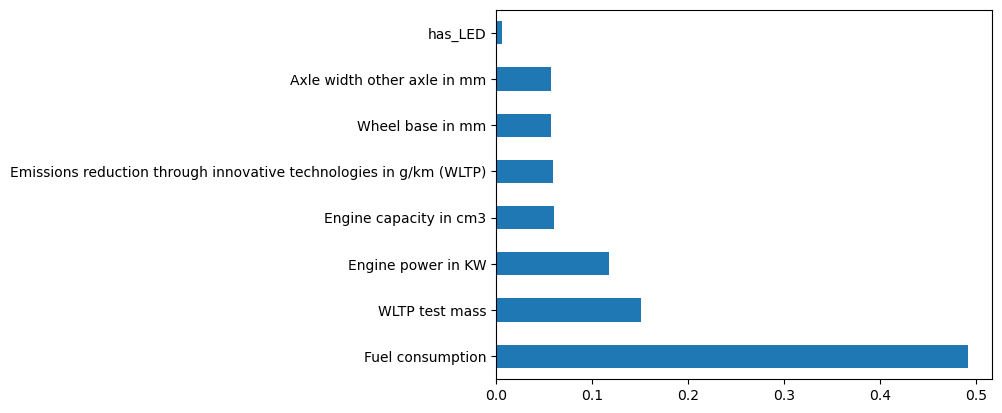

In [17]:
feat_importances = pd.Series(
    rf_best.feature_importances_,df_numeric.drop(columns=['Specific CO2 Emissions in g/km (WLTP)']).columns)
feat_importances.nlargest(15).plot(kind='barh');

## DTC+Boosting

In [18]:
# X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=90000))
# dtc = DecisionTreeClassifier(random_state=66)

# param_grid = {'criterion':["gini","entropy"],
# 'max_depth': [15, 20, 25, None],
# 'min_samples_leaf': [15, 25, 30],
# 'min_samples_split': [15, 20,30]}


# grid_clf_dtc = model_selection.GridSearchCV(dtc, param_grid, cv=5, scoring = ['accuracy', 'f1_macro'], refit='accuracy', verbose=1, n_jobs=-1)

# grille_dtc = grid_clf_dtc.fit(X_train_scaled,y_train)

# display(pd.DataFrame.from_dict(grille_dtc.cv_results_).sort_values(by=['mean_test_accuracy', 'mean_test_f1_macro'],ascending=[False,False]).head(5).loc[:,['params', 'mean_test_f1_macro', 'mean_test_accuracy', 'std_test_f1_macro', 'std_test_accuracy']])
# print("Best hyperparameters: ", grille_dtc.best_params_)


In [19]:
X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=2000000))
dtc = DecisionTreeClassifier(random_state=66, criterion='entropy', max_depth=20, min_samples_leaf=15, min_samples_split=15)

dtc.fit(X_train_scaled, y_train)
print('Train Score:',dtc.score(X_train_scaled, y_train))

y_pred = dtc.predict(X_test_scaled)
show_scores(y_test,y_pred)
#display_ct(y_test, y_pred)

Train Score: 0.97937
Accuracy: 0.9775125
F1-Score: 0.9774309975914722
Precision: 0.9774266188421029
Recall: 0.9774634583074793


In [20]:
# X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=90000))

# dtc2 = DecisionTreeClassifier(random_state=66, criterion='entropy', max_depth=20, min_samples_leaf=15, min_samples_split=15)
# ac2 = AdaBoostClassifier(estimator=dtc2, random_state=66, algorithm='SAMME')

# parameters = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [(0.97 + x / 100) for x in range(0, 8)]
# }

# grid_clf_ac = model_selection.GridSearchCV(ac2, parameters, cv=5, scoring = ['accuracy', 'f1_macro'], refit='accuracy', verbose=1, n_jobs=-1)

# grille_ac = grid_clf_ac.fit(X_train_scaled,y_train)

# display(pd.DataFrame.from_dict(grille_ac.cv_results_).sort_values(by=['mean_test_accuracy', 'mean_test_f1_macro'],ascending=[False,False]).head(5).loc[:,['params', 'mean_test_f1_macro', 'mean_test_accuracy', 'std_test_f1_macro', 'std_test_accuracy']])
# print("Best hyperparameters: ", grille_ac.best_params_)

In [21]:
X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=2000000))

ac_best = AdaBoostClassifier(estimator=dtc, random_state=66, algorithm='SAMME', n_estimators=50, learning_rate=1.01)

ac_best.fit(X_train_scaled, y_train)

print('Train Score:',ac_best.score(X_train_scaled, y_train))

y_pred = ac_best.predict(X_test_scaled)
show_scores(y_test,y_pred)

Train Score: 0.98683
Accuracy: 0.981755
F1-Score: 0.981699847042696
Precision: 0.9817043108017257
Recall: 0.9817118379491419


## KNN

In [22]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=3, metric='minkowski')

knn_clf.fit(X_train_scaled, y_train)

print('Train Score:',knn_clf.score(X_train_scaled, y_train))

y_pred = knn_clf.predict(X_test_scaled)
show_scores(y_test,y_pred)
#display_ct(y_test, y_pred)

Train Score: 0.98387375
Accuracy: 0.97993
F1-Score: 0.9798564549322386
Precision: 0.979943251870897
Recall: 0.9797756473750013


In [23]:
# X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=90000))

# xgb_clf = xgb.XGBClassifier(n_jobs=-1, random_state=66)

# param_grid = {
#     'max_depth': [15, 20, 25, None],
#     'learning_rate': [0.1, 0.15, 0.2],
#     'subsample': [0.5, 0.7, 1]
# }

# grid_clf_xgb = model_selection.GridSearchCV(xgb_clf, param_grid, cv=5, scoring = ['accuracy', 'f1_macro'], refit='accuracy', verbose=True)

# grille_xgb = grid_clf_xgb.fit(X_train_scaled,y_train)

# display(pd.DataFrame.from_dict(grille_xgb.cv_results_).sort_values(by=['mean_test_accuracy', 'mean_test_f1_macro'],ascending=[False,False]).head(5).loc[:,['params', 'mean_test_f1_macro', 'mean_test_accuracy', 'std_test_f1_macro', 'std_test_accuracy']])
# print("Best hyperparameters: ", grille_xgb.best_params_)


In [24]:
X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=2000000))
xgb_best = xgb.XGBClassifier(n_jobs=-1, random_state=66, max_depth=20, learning_rate=0.2, subsample=0.7)

xgb_best.fit(X_train_scaled,y_train)

print('Train Score:',xgb_best.score(X_train_scaled, y_train))

y_pred = xgb_best.predict(X_test_scaled)
show_scores(y_test,y_pred)
#display_ct(y_test, y_pred)

Train Score: 0.9824825
Accuracy: 0.9786325
F1-Score: 0.9785493943641687
Precision: 0.9785689911360009
Recall: 0.9785460297657037


## Bagging

In [25]:
# X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=50000))

# bag_clf = BaggingClassifier(random_state=66, oob_score=True)

# parameters = {
#     'max_samples': [0.95],
#     'n_estimators': [200],
#     'max_features': [0.92, 0.95, 0.98],
#     'bootstrap_features':[False]
# }

# grid_clf_bag = model_selection.GridSearchCV(bag_clf, parameters, cv=5, scoring = ['accuracy', 'f1_macro'], refit='accuracy', verbose=1, n_jobs=-1)

# grille_bag = grid_clf_bag.fit(X_train_scaled,y_train)

# display(pd.DataFrame.from_dict(grille_bag.cv_results_).sort_values(by=['mean_test_accuracy', 'mean_test_f1_macro'],ascending=[False,False]).head(5).loc[:,['params', 'mean_test_f1_macro', 'mean_test_accuracy', 'std_test_f1_macro', 'std_test_accuracy']])
# print("Best hyperparameters: ", grille_bag.best_params_)

In [26]:
X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=2000000))

bag_best = BaggingClassifier(max_features=0.92, max_samples=0.95, bootstrap_features=False, oob_score=True, random_state=66, n_estimators=200)
bag_best.fit(X_train_scaled,y_train)

print('Train Score:',bag_best.score(X_train_scaled, y_train))

y_pred = bag_best.predict(X_test_scaled)
show_scores(y_test,y_pred)
#display_ct(y_test, y_pred)

Train Score: 0.988068125
Accuracy: 0.9831625
F1-Score: 0.9831010226261144
Precision: 0.9831216497830286
Recall: 0.9831070871870755


## Voting

In [27]:
X_train_scaled, X_test_scaled, y_train, y_test = scale_train_test_split(df_numeric.sample(n=2000000))
vclf = VotingClassifier(estimators=[('dtc_ac', ac_best) ,('xgb', xgb_best), ('rf', rf_best), ('bagging', bag_best), ('knn', knn_clf)], voting='soft', verbose=True)
vclf.fit(X_train_scaled,y_train)

print('Train Score:',vclf.score(X_train_scaled, y_train))

y_pred = vclf.predict(X_test_scaled)
show_scores(y_test,y_pred)
display_ct(y_test, y_pred)

[Voting] ................... (1 of 5) Processing dtc_ac, total= 3.5min
[Voting] ...................... (2 of 5) Processing xgb, total=  49.9s
[Voting] ....................... (3 of 5) Processing rf, total= 2.2min
[Voting] .................. (4 of 5) Processing bagging, total= 6.9min
[Voting] ...................... (5 of 5) Processing knn, total=   0.9s
Train Score: 0.987305
Accuracy: 0.982785
F1-Score: 0.9827342702647963
Precision: 0.9827363287815432
Recall: 0.9827404065490741

Croostab:


Predicted Class,0%-10%,10%+,20%+,30%+,40%+,50%+,60%+,70%+,80%+,90%+
Real Class,,,,,,,,,,
0%-10%,39838,164,2,1,4,0,0,0,0,0
10%+,81,40244,78,6,4,0,0,0,1,0
20%+,0,106,41056,576,12,4,1,0,0,0
30%+,0,5,478,36388,333,3,4,0,0,0
40%+,0,6,58,406,43512,435,11,6,1,0
50%+,0,0,0,2,389,35664,495,17,1,0
60%+,0,0,1,2,11,306,39217,617,5,6
70%+,0,0,0,1,4,13,749,38192,418,47
80%+,0,0,1,0,1,1,4,382,42687,276



Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40009
           1       0.99      1.00      0.99     40414
           2       0.99      0.98      0.98     41755
           3       0.97      0.98      0.98     37211
           4       0.98      0.98      0.98     44435
           5       0.98      0.98      0.98     36568
           6       0.97      0.98      0.97     40165
           7       0.97      0.97      0.97     39424
           8       0.98      0.98      0.98     43352
           9       0.99      0.99      0.99     36667

    accuracy                           0.98    400000
   macro avg       0.98      0.98      0.98    400000
weighted avg       0.98      0.98      0.98    400000



--------------------------------------

In [29]:
import pickle

# save the bag_best classification model as a pickle file
model_pkl_file = "bagging.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(bag_best, file)
    


In [ ]:
# # load model from pickle file
# model_pkl_file = "bagging.pkl"

# with open(model_pkl_file, 'rb') as file:  
#     bag_best = pickle.load(file)